In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    roi_size_x = min(int(width // 2), width)   
    roi_size_y = min(int(height // 2), height)

    center_x, center_y = width // 2, height // 2
    x1, x2 = max(0, center_x - roi_size_x // 2), min(width, center_x + roi_size_x // 2)
    y1, y2 = max(0, center_y - roi_size_y // 2), min(height, center_y + roi_size_y // 2)

    roi_larger_middle_original = image[y1:y2, x1:x2]

    # plt.figure(figsize=(12, 6))
    # plt.title("Original Image for Larger Middle Section")
    # plt.imshow(cv2.cvtColor(roi_larger_middle_original, cv2.COLOR_BGR2RGB))
    # plt.axis("off")
    # plt.show()

    roi_gray = cv2.cvtColor(roi_larger_middle_original, cv2.COLOR_BGR2GRAY)
    _, roi_binary = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # plt.figure(figsize=(12, 6))
    # plt.title("Binary Image for Larger Middle Section")
    # plt.imshow(roi_binary, cmap="gray")
    # plt.axis("off")
    # plt.show()

    return roi_binary, roi_larger_middle_original


def enhance_lines(binary_image):
    smoothed = cv2.GaussianBlur(binary_image, (3, 3), 0)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 1))
    morphed = cv2.morphologyEx(smoothed, cv2.MORPH_CLOSE, horizontal_kernel)

    # plt.figure(figsize=(12, 6))
    # plt.title("Smoothed Binary Image with Enhanced Lines")
    # plt.imshow(morphed, cmap="gray")
    # plt.axis("off")
    # plt.show()

    return morphed


def extract_middle_section(morphed_image):
    height, width = morphed_image.shape
    # x, y, w, h = width // 6, height // 6, 2 * width // 3, 2 * height // 3
    # roi_middle_large = morphed_image[y:y+h, x:x+w]

    roi_size_x = min(int(width // 2), width)   
    roi_size_y = min(int(height // 2), height)

    center_x, center_y = width // 2, height // 2
    x1, x2 = max(0, center_x - roi_size_x // 2), min(width, center_x + roi_size_x // 2)
    y1, y2 = max(0, center_y - roi_size_y // 2), min(height, center_y + roi_size_y // 2)

    roi_middle_large = morphed_image[y1:y2, x1:x2]

    # plt.figure(figsize=(12, 6))
    # plt.title("Extracted Larger Middle Section")
    # plt.imshow(roi_middle_large, cmap="gray")
    # plt.axis("off")
    # plt.show()

    return roi_middle_large


def process_binary_image(roi_middle_large):
    height, width = roi_middle_large.shape
    _, roi_binary_large = cv2.threshold(roi_middle_large, 50, 255, cv2.THRESH_BINARY_INV)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
    morphed_roi_large = cv2.morphologyEx(roi_binary_large, cv2.MORPH_CLOSE, horizontal_kernel)

    # plt.figure(figsize=(12, 6))
    # plt.title("Binary Image of Larger Middle Section with Enhanced Lines")
    # plt.imshow(morphed_roi_large, cmap="gray")
    # plt.axis("off")
    # plt.show()

    return morphed_roi_large


def process_binary_image_vertical(roi_middle_large):
    _, roi_binary_large = cv2.threshold(roi_middle_large, 50, 255, cv2.THRESH_BINARY_INV)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 5))
    morphed_roi_large = cv2.morphologyEx(roi_binary_large, cv2.MORPH_CLOSE, horizontal_kernel)

    # plt.figure(figsize=(12, 6))
    # plt.title("Binary Image of Larger Middle Section with Enhanced Lines - Vertical")
    # plt.imshow(morphed_roi_large, cmap="gray")
    # plt.axis("off")
    # plt.show()

    return morphed_roi_large

def detect_and_filter_lines(morphed_roi_large):
    contours_large, _ = cv2.findContours(morphed_roi_large, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    def filter_horizontal_contours(contours, min_aspect_ratio=1.5):
        horizontal_lines = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w / h >= min_aspect_ratio:
                horizontal_lines.append((x, y, w, h))
        return horizontal_lines

    horizontal_lines_filtered = filter_horizontal_contours(contours_large, min_aspect_ratio=5)

    return horizontal_lines_filtered


def calculate_line_statistics(horizontal_lines_filtered):
    line_lengths = [w for _, _, w, _ in horizontal_lines_filtered]
    line_widths = [h for _, _, _, h in horizontal_lines_filtered]

    median_length = np.median(line_lengths) if line_lengths else 0
    median_width = np.median(line_widths) if line_widths else 0
    avg_length = np.mean(line_lengths) if line_lengths else 0
    avg_width = np.mean(line_widths) if line_widths else 0

    valid_lines = len(horizontal_lines_filtered)

    return median_length, median_width, valid_lines, avg_length, avg_width

def convert_to_mm(median_length, median_width, avg_length, avg_width, pixels_per_mm=6.55*4):
    median_length_mm = median_length / pixels_per_mm
    median_width_mm = median_width / pixels_per_mm
    avg_length_mm = avg_length / pixels_per_mm
    avg_width_mm = avg_width / pixels_per_mm

    return median_length_mm, median_width_mm, avg_length_mm, avg_width_mm

def calculate_gaps_with_dimensions(horizontal_lines_filtered, pixels_per_mm=6.55*4):
    horizontal_lines_filtered.sort(key=lambda line: line[1])

    gap_heights = [] 
    gap_widths = [] 

    for i in range(len(horizontal_lines_filtered) - 1):
        x_current, y_current, w_current, h_current = horizontal_lines_filtered[i]
        x_next, y_next, w_next, h_next = horizontal_lines_filtered[i + 1]

        gap_height = y_next - (y_current + h_current)  
        gap_width = min(w_current, w_next)  
        if gap_height > 0: 
            gap_heights.append(gap_height)
            gap_widths.append(gap_width)

    gap_heights_mm = [gap / pixels_per_mm for gap in gap_heights]
    gap_widths_mm = [gap / pixels_per_mm for gap in gap_widths]

    median_gap_height_mm = np.median(gap_heights_mm) if gap_heights_mm else 0
    avg_gap_height_mm = min(gap_heights_mm) if gap_heights_mm else 0

    median_gap_width_mm = np.median(gap_widths_mm) if gap_widths_mm else 0
    avg_gap_width_mm = min(gap_widths_mm) if gap_widths_mm else 0

    return median_gap_height_mm, avg_gap_height_mm, median_gap_width_mm, avg_gap_width_mm, len(gap_heights)

def visualize_lines(morphed_roi_large, horizontal_lines_filtered):
    output_horizontal_lines = cv2.cvtColor(morphed_roi_large, cv2.COLOR_GRAY2BGR)
    for x, y, w, h in horizontal_lines_filtered:
        cv2.rectangle(output_horizontal_lines, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize=(12, 6))
    plt.title("Filtered Horizontal Lines Visualization")
    plt.imshow(cv2.cvtColor(output_horizontal_lines, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [ ]:
csv_filename = "line_measurements.csv"
columns = ["Image",
           "Median Average Average Average Average Average Average Average Line Length (mm)", "Median Line Width (mm)", 
           "Average Line Length (mm)", "Average Line Width (mm)", 
           "Average Gap Length (mm)", "Average Gap Width (mm)", 
           "Median Gap Length (mm)", "Median Gap Width (mm)"]


def main(image_path, csv_filename):
    if os.path.exists(csv_filename):
        df_results = pd.read_csv(csv_filename)
    print("Image is ", image_path)
    roi_binary, roi_larger_middle_original = preprocess_image(image_path)
    morphed = enhance_lines(roi_binary)
    roi_middle_large = extract_middle_section(morphed)
    morphed_roi_large = process_binary_image(roi_middle_large)
    horizontal_lines_filtered = detect_and_filter_lines(morphed_roi_large)
    median_length, median_width, valid_lines, avg_length, avg_width = calculate_line_statistics(horizontal_lines_filtered)
    median_length_mm, median_width_mm, avg_length_mm, avg_width_mm = convert_to_mm(median_length, median_width, avg_length, avg_width)
    median_gap_height_mm, avg_gap_height_mm, median_gap_width_mm, avg_gap_width_mm, _ = calculate_gaps_with_dimensions(horizontal_lines_filtered)
    visualize_lines(morphed_roi_large, horizontal_lines_filtered)

    print("In millimeters")
    print(f"Median Gap Length: {median_gap_height_mm:.4f} mm")
    print(f"Median Gap Width: {median_gap_width_mm:.4f} mm")
    print(f"Average Gap Length: {avg_gap_height_mm:.4f} mm")
    print(f"Average Ga Width: {avg_gap_width_mm:.4f} mm")

    new_row = pd.DataFrame([{
            "Image": image_path,
            "Median Line Length (mm)": median_length_mm,
            "Median Line Width (mm)": median_width_mm,
            "Average Line Length (mm)": avg_length_mm,
            "Average Line Width (mm)": avg_width_mm,
            "Average Gap Length (mm)": avg_gap_height_mm, 
            "Average Gap Width (mm)": avg_gap_width_mm/10, 
           "Median Gap Length (mm)":median_gap_height_mm, 
           "Median Gap Width (mm):": median_gap_width_mm/10
        }])
    df_results = pd.concat([df_results, new_row], ignore_index=True)
    df_results.to_csv(csv_filename, index=False)
    

Image is  0.2kvDC.jpg


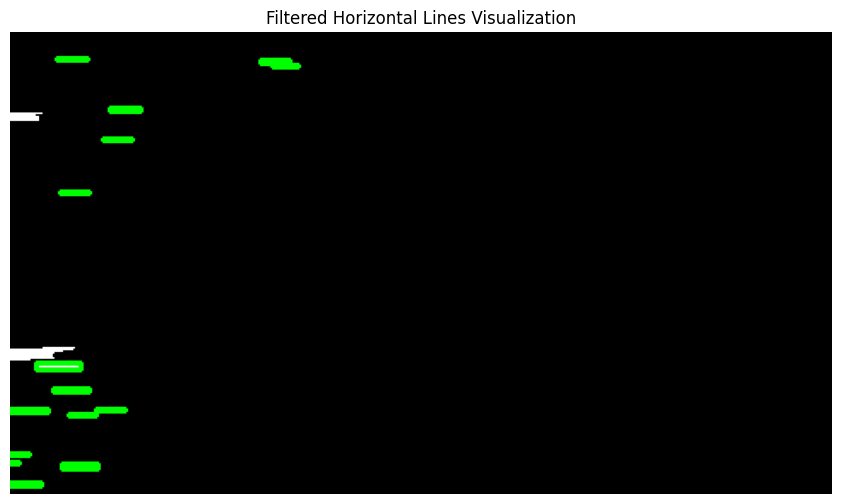

In millimeters
Median Gap Length: 0.4198 mm
Median Gap Width: 0.6489 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.1908 mm
Image is  0.4kVDC.jpg


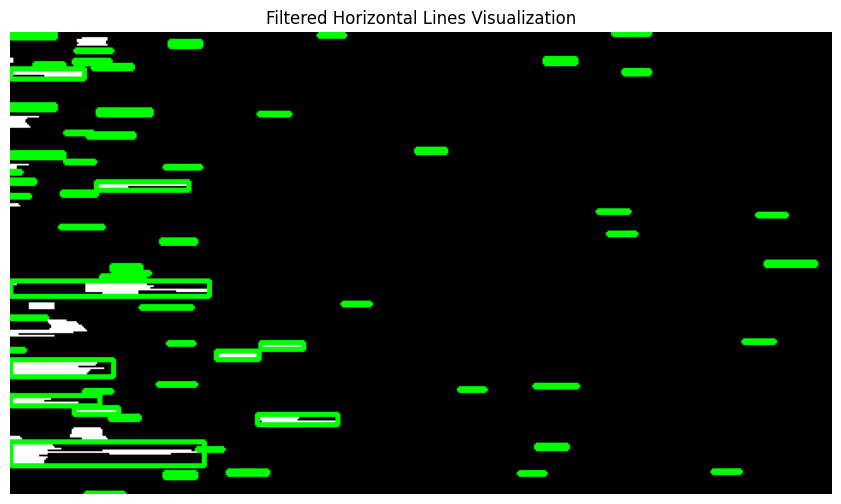

In millimeters
Median Gap Length: 0.1145 mm
Median Gap Width: 0.6489 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.2290 mm
Image is  0.6kvDC.jpg


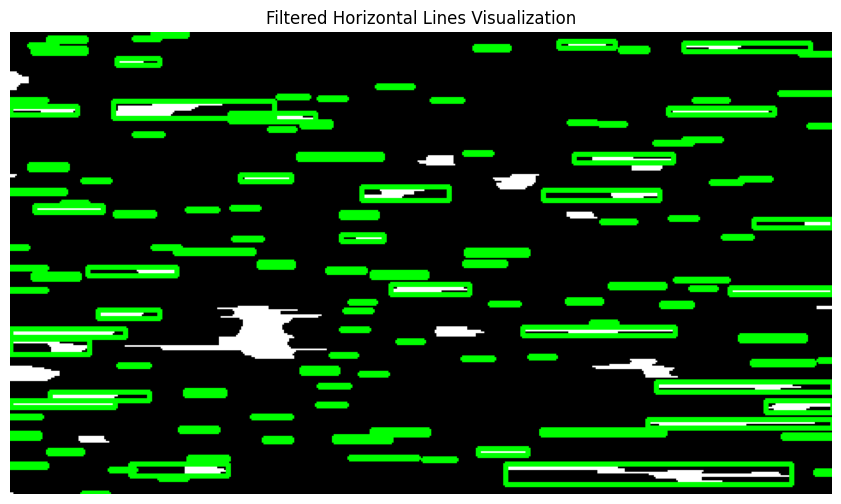

In millimeters
Median Gap Length: 0.0763 mm
Median Gap Width: 0.6489 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.3817 mm
Image is  0.8kvDC.jpg


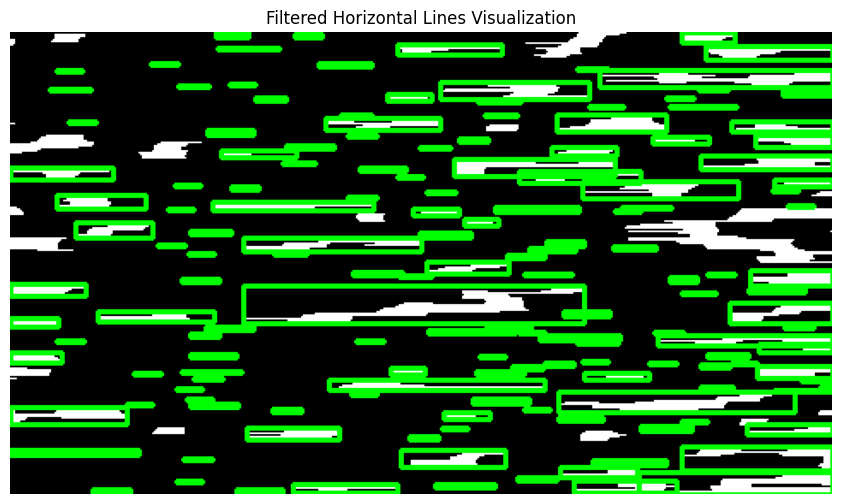

In millimeters
Median Gap Length: 0.0763 mm
Median Gap Width: 0.6489 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.5725 mm
Image is  1kvDC.jpg


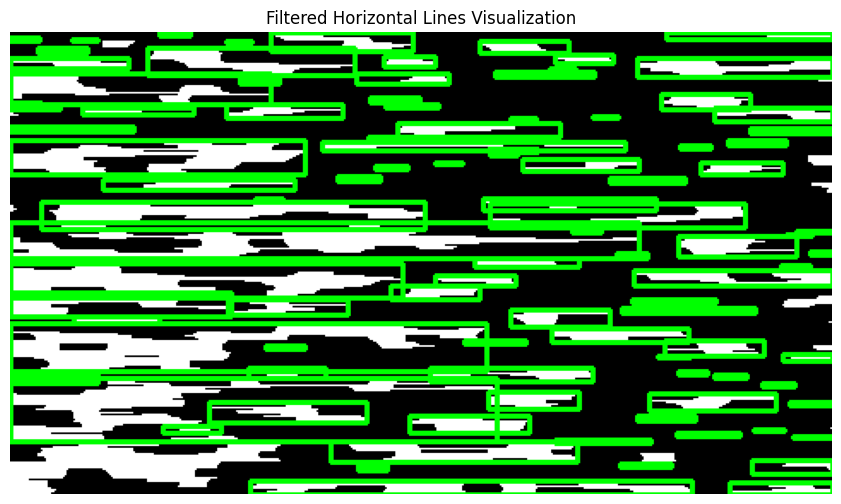

In millimeters
Median Gap Length: 0.0763 mm
Median Gap Width: 0.6679 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.5725 mm
Image is  0.5kVAC.jpg


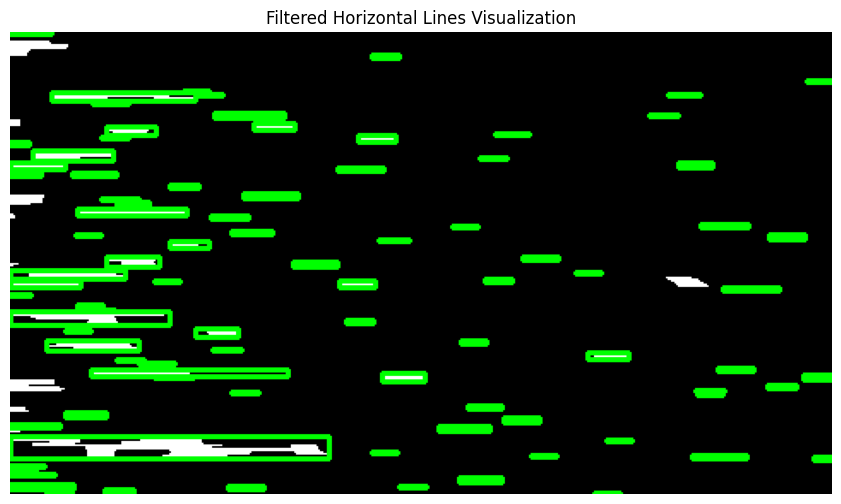

In millimeters
Median Gap Length: 0.0954 mm
Median Gap Width: 0.6107 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.4198 mm
Image is  1kvAC.jpg


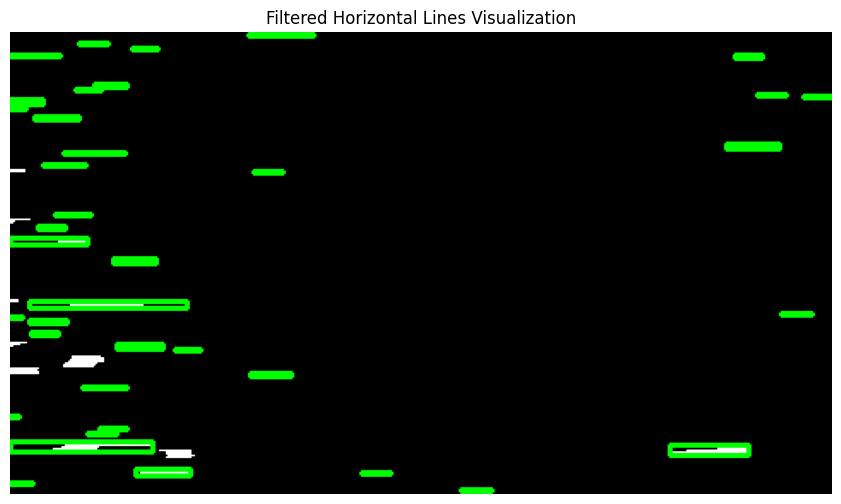

In millimeters
Median Gap Length: 0.1718 mm
Median Gap Width: 0.6107 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.1908 mm
Image is  2kvAC.jpg


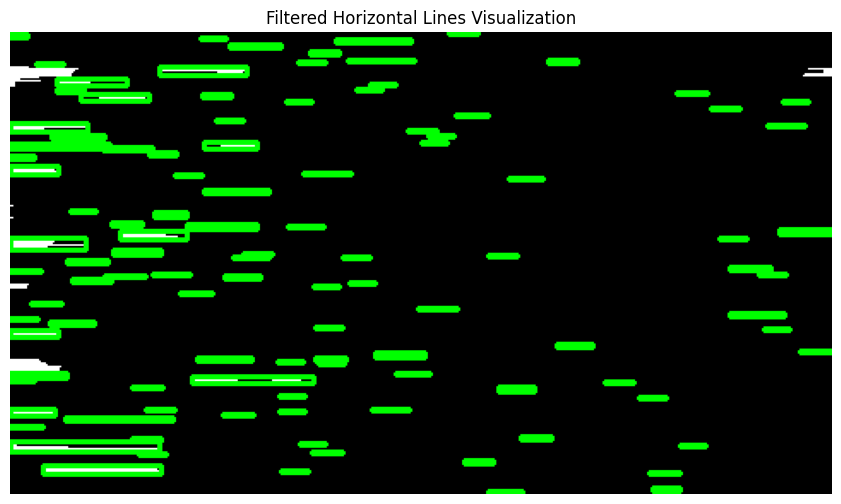

In millimeters
Median Gap Length: 0.0763 mm
Median Gap Width: 0.6107 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.5344 mm
Image is  3kvAC.jpg


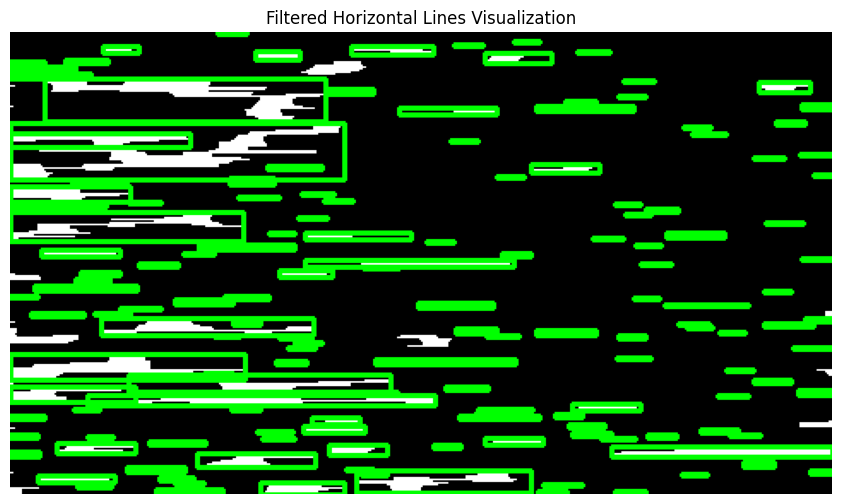

In millimeters
Median Gap Length: 0.0382 mm
Median Gap Width: 0.6298 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.4198 mm
Image is  0.1kvDC.jpg


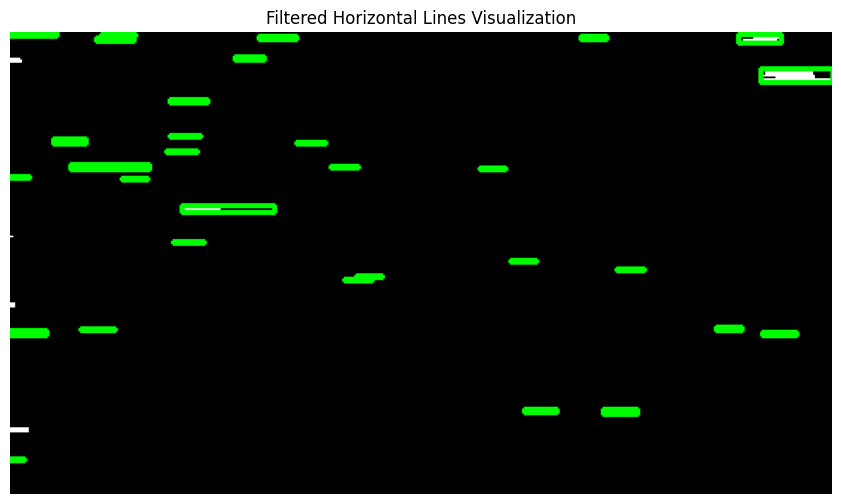

In millimeters
Median Gap Length: 0.3435 mm
Median Gap Width: 0.6489 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.3053 mm
Image is  0.3kvDC.jpg


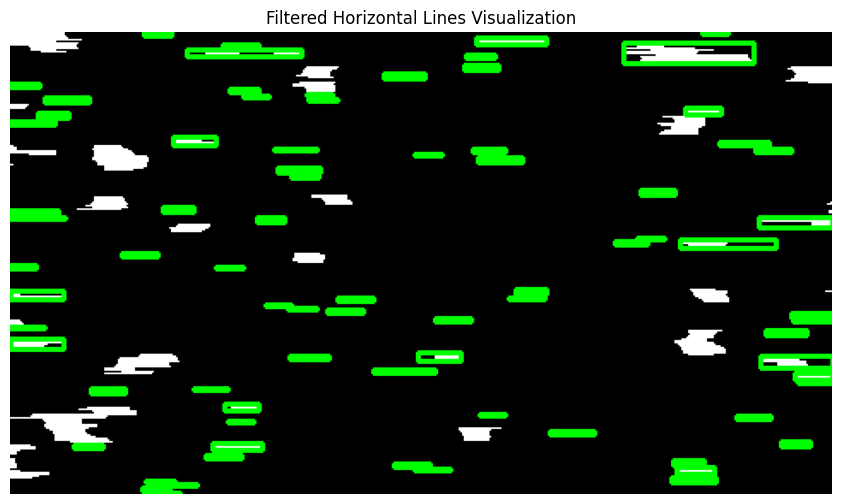

In millimeters
Median Gap Length: 0.0763 mm
Median Gap Width: 0.6489 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.5725 mm
Image is  0.5kvDC.jpg


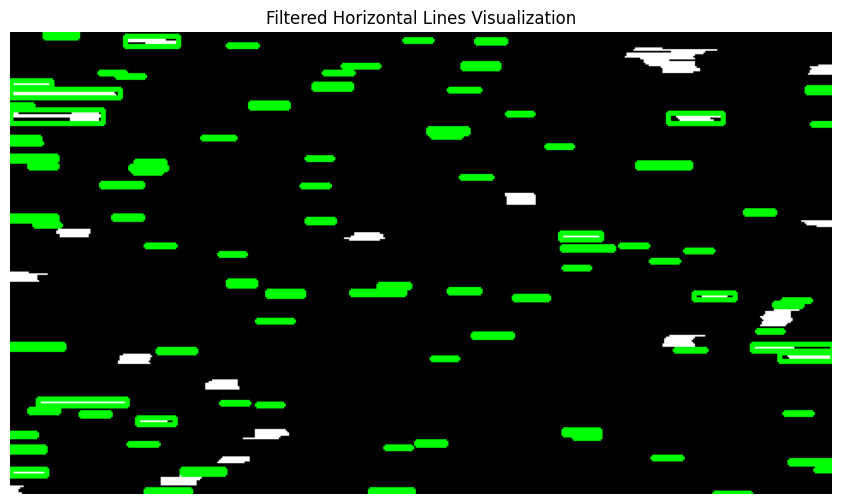

In millimeters
Median Gap Length: 0.0763 mm
Median Gap Width: 0.6107 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.3817 mm
Image is  0.7kvDC.jpg


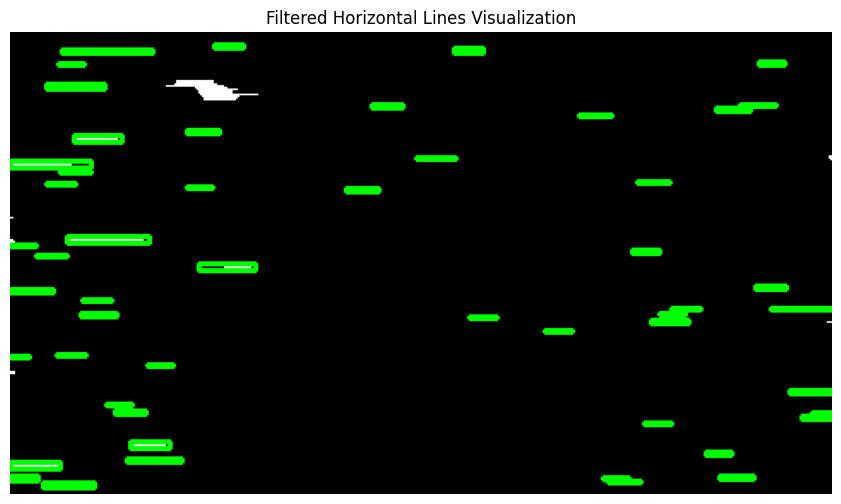

In millimeters
Median Gap Length: 0.1527 mm
Median Gap Width: 0.6107 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.4198 mm
Image is  0.9kvDC.jpg


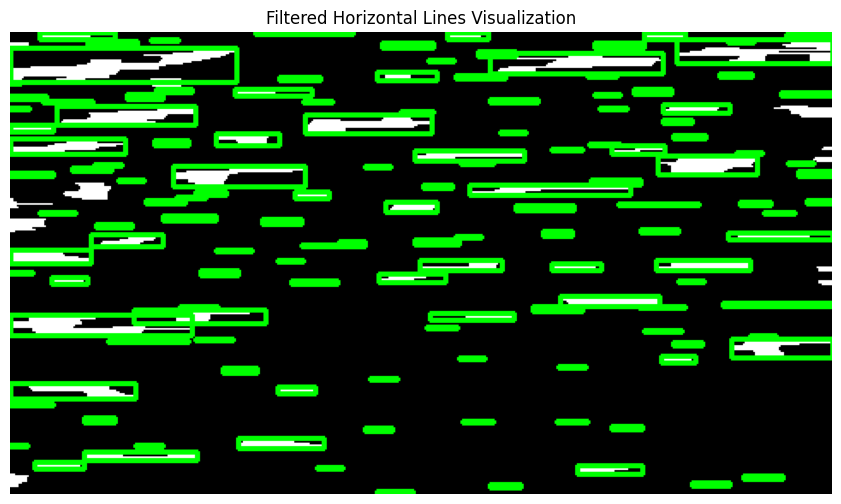

In millimeters
Median Gap Length: 0.0763 mm
Median Gap Width: 0.6489 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.2290 mm
Image is  1.5kvAC.jpg


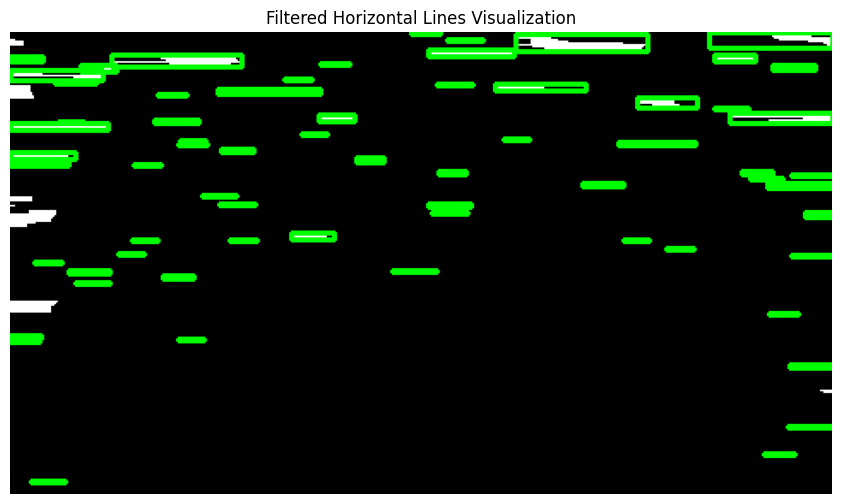

In millimeters
Median Gap Length: 0.1145 mm
Median Gap Width: 0.6489 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.5725 mm
Image is  2.5kvAC.jpg


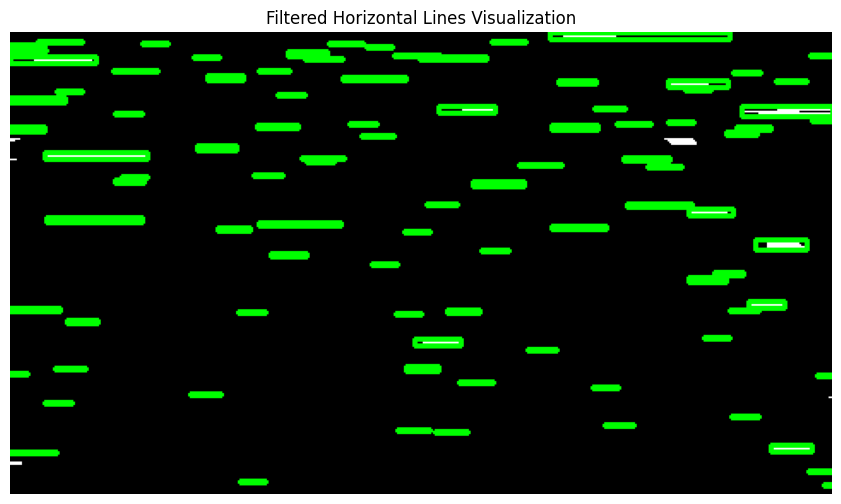

In millimeters
Median Gap Length: 0.1145 mm
Median Gap Width: 0.6107 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.1908 mm
Image is  2.7kvAC.jpg


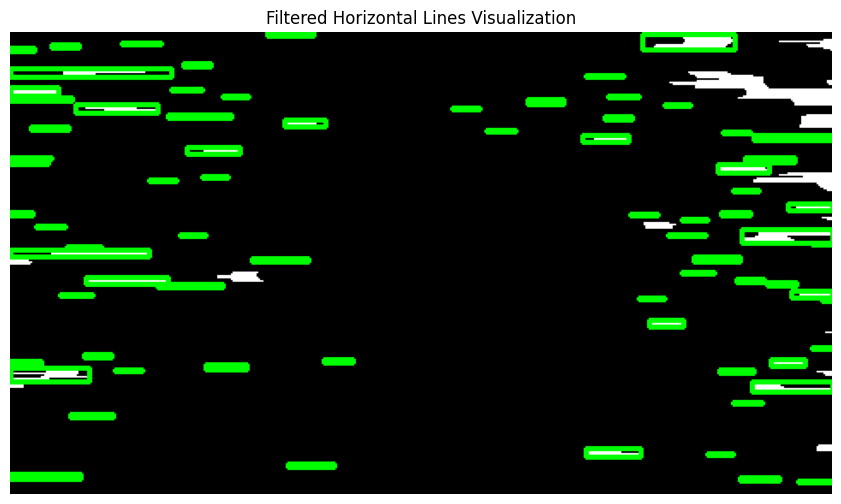

In millimeters
Median Gap Length: 0.1145 mm
Median Gap Width: 0.6107 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.2290 mm
Image is  2.9kvAC.jpg


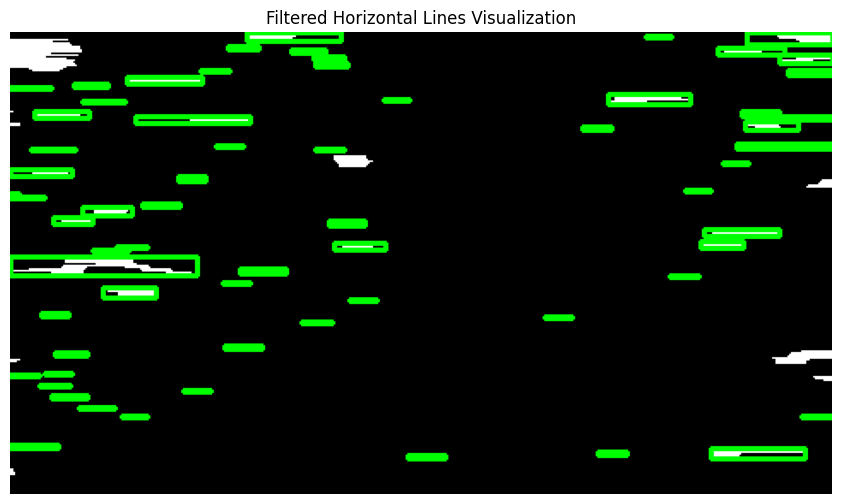

In millimeters
Median Gap Length: 0.1145 mm
Median Gap Width: 0.6489 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.1908 mm
Image is  3.1kvAC.jpg


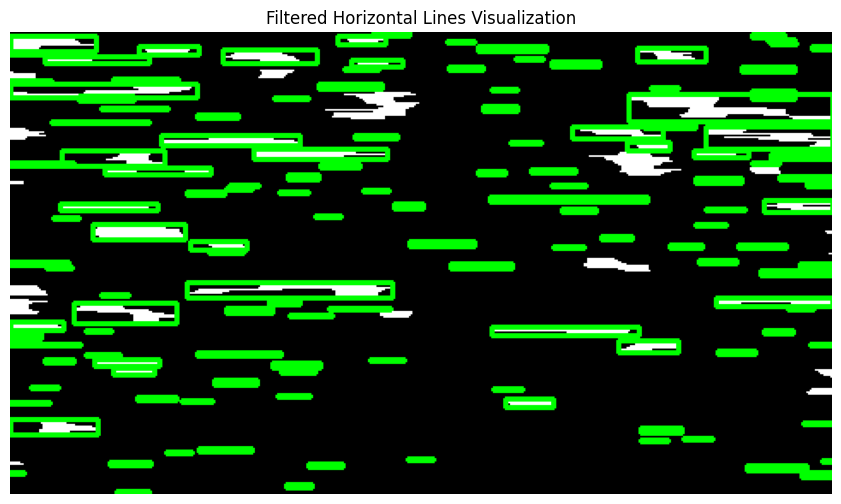

In millimeters
Median Gap Length: 0.0763 mm
Median Gap Width: 0.6870 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.3053 mm
Image is  3.3kvAC.jpg


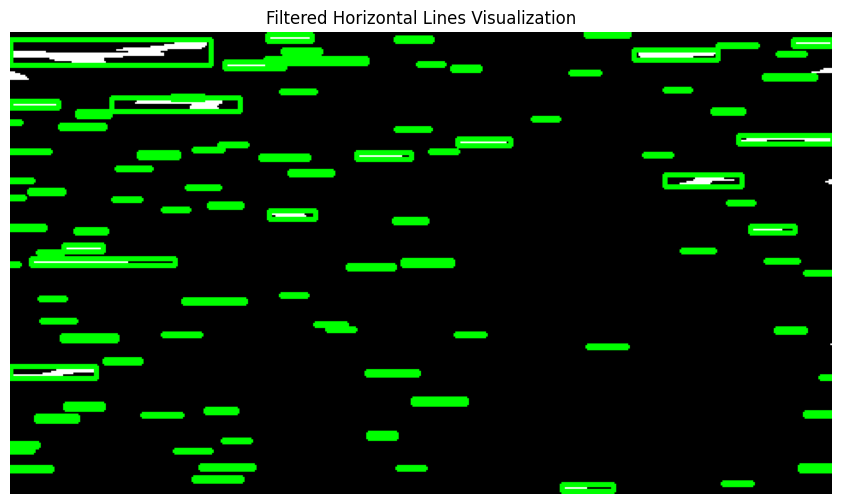

In millimeters
Median Gap Length: 0.0763 mm
Median Gap Width: 0.6107 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.2290 mm
Image is  3.5kvAC.jpg


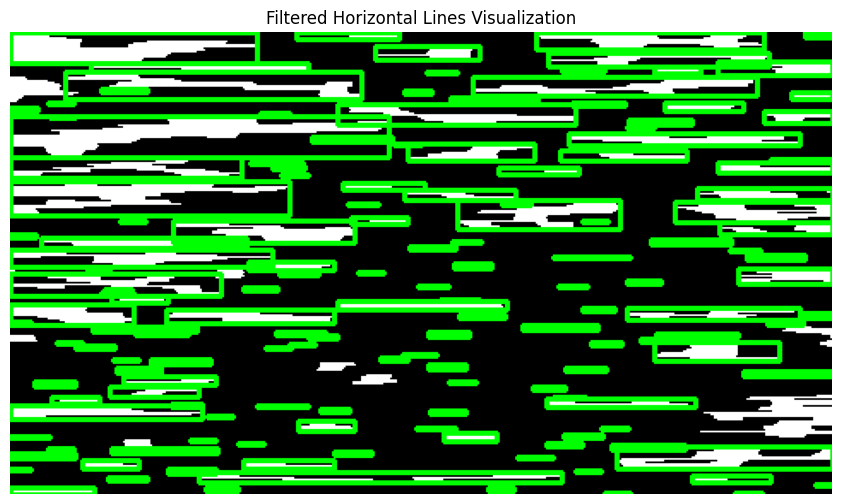

In millimeters
Median Gap Length: 0.0382 mm
Median Gap Width: 0.6107 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.3817 mm
Image is  4.5kvAC.jpg


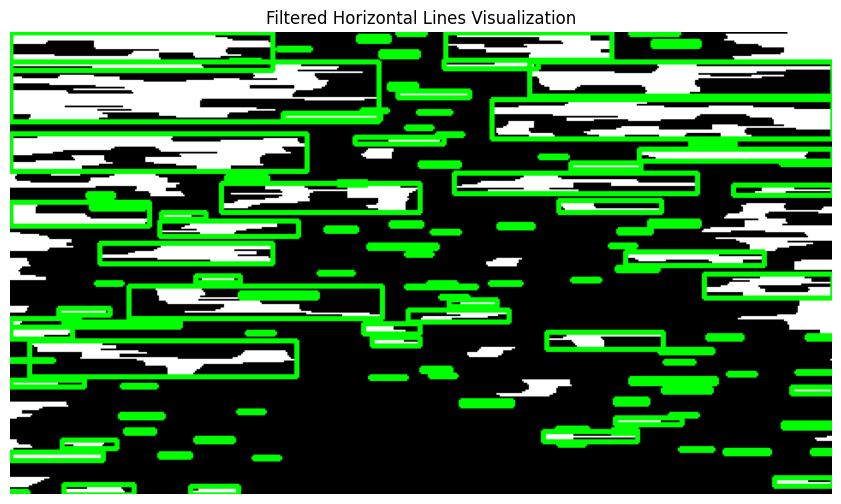

In millimeters
Median Gap Length: 0.0763 mm
Median Gap Width: 0.6298 mm
Average Gap Length: 0.0382 mm
Average Ga Width: 0.5725 mm


In [6]:
images = [
    "0.2kvDC.jpg",
    "0.4kVDC.jpg",
    "0.6kvDC.jpg",
    "0.8kvDC.jpg",
    "1kvDC.jpg",
    "0.5kVAC.jpg",
    "1kvAC.jpg",
    "2kvAC.jpg",
    "3kvAC.jpg",
    "0.1kvDC.jpg",
    "0.3kvDC.jpg",
    "0.5kvDC.jpg",
    "0.7kvDC.jpg",
    "0.9kvDC.jpg",
    "1.5kvAC.jpg",
    "2.5kvAC.jpg",
    "2.7kvAC.jpg",
    "2.9kvAC.jpg",
    "3.1kvAC.jpg",
    "3.3kvAC.jpg",
    "3.5kvAC.jpg",
    "4.5kvAC.jpg"
    ]

for image in images:
    main(image, csv_filename)


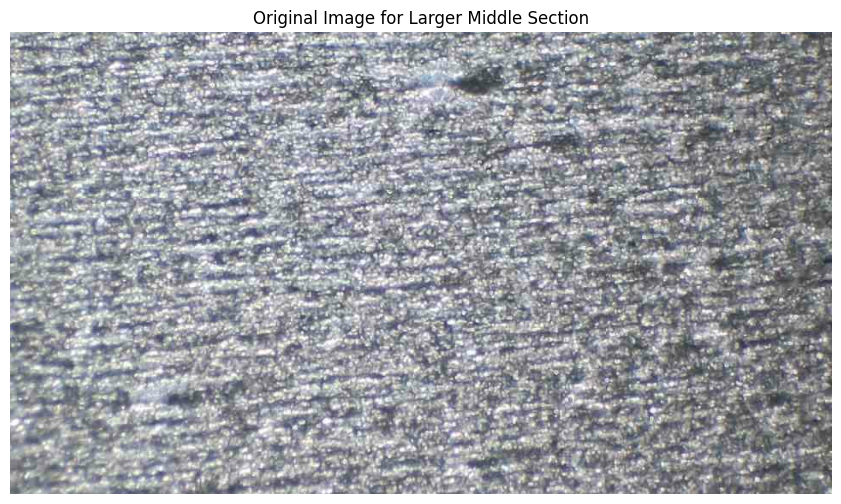

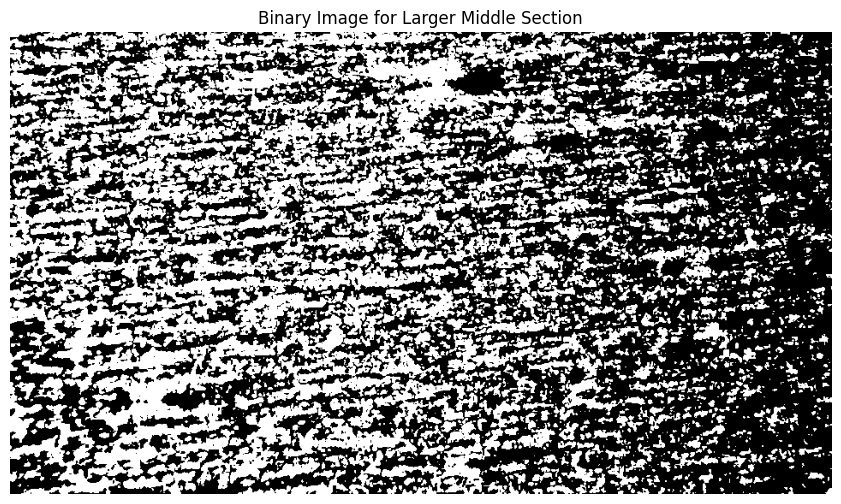

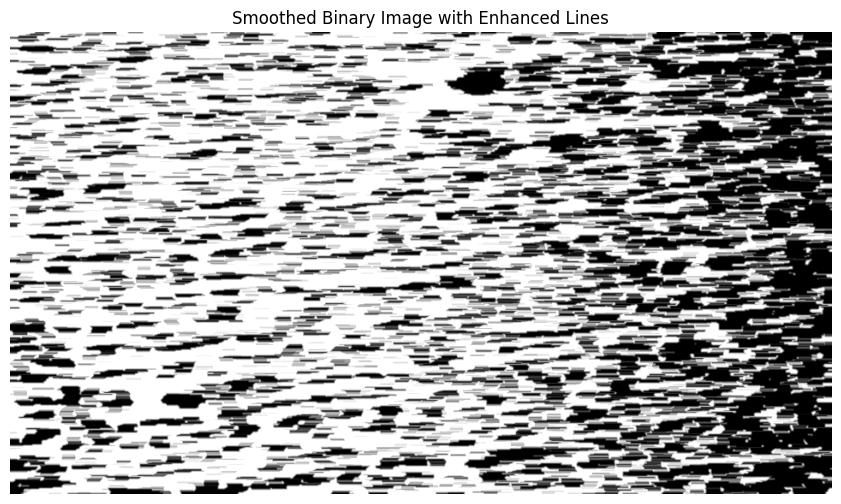

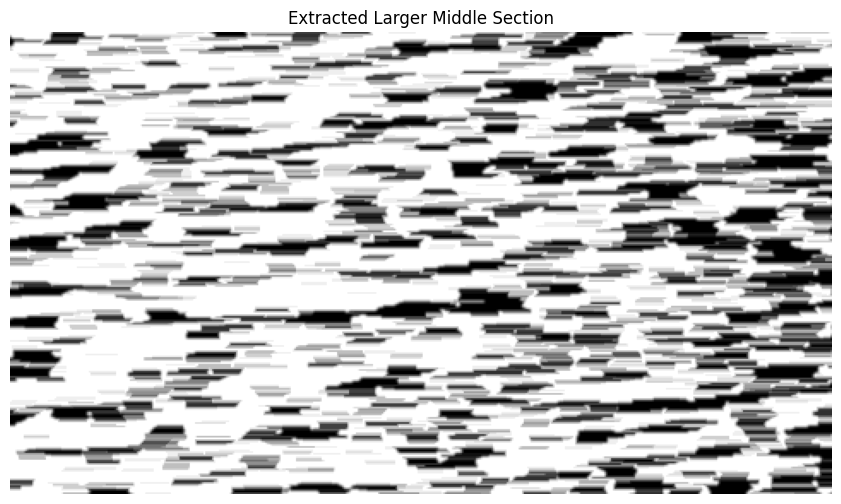

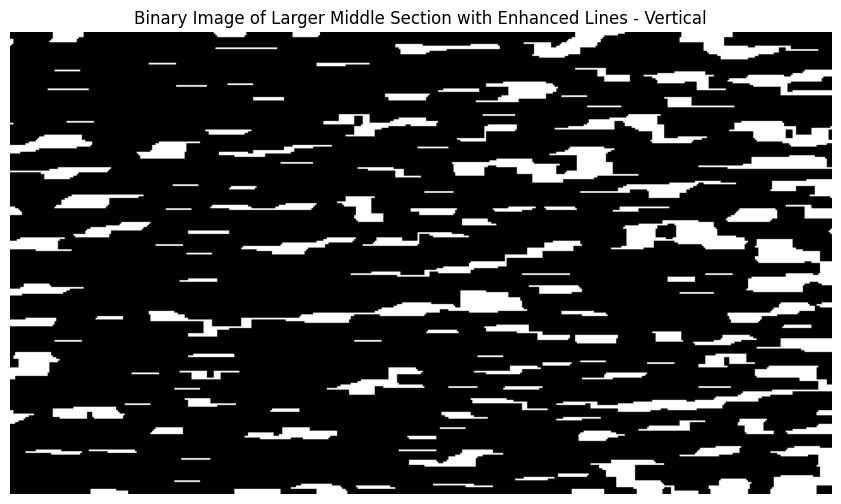

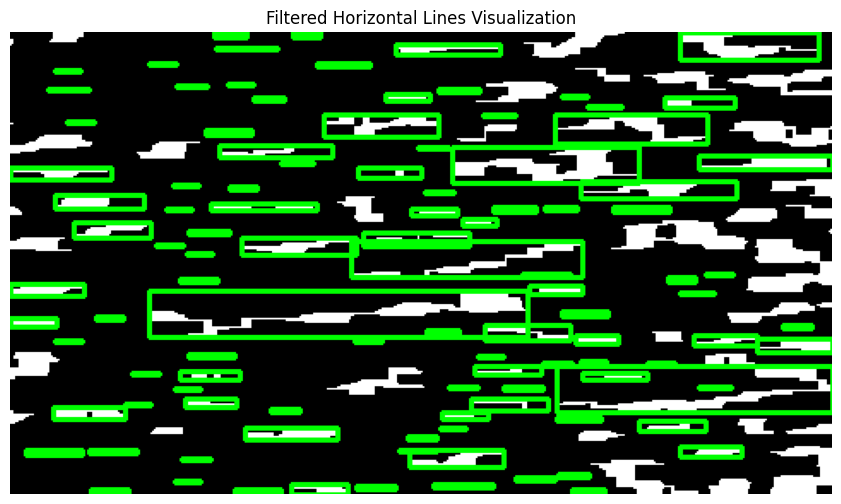

Median Line Length: 24.00 pixels
Median Line Width: 2.00 pixels
Average Line Length: 34.70 pixels
Average Line Width: 4.38 pixels
Total Number of Horizontal Lines: 107


In [109]:
image_path = "0.8kvDC.jpg"
roi_binary, roi_larger_middle_original = preprocess_image(image_path)
morphed = enhance_lines(roi_binary)
roi_middle_large = extract_middle_section(morphed)
morphed_roi_large = process_binary_image_vertical(roi_middle_large)
horizontal_lines_filtered = detect_and_filter_lines(morphed_roi_large)
median_length, median_width, valid_lines, avg_length, avg_width = calculate_line_statistics(horizontal_lines_filtered)
visualize_lines(morphed_roi_large, horizontal_lines_filtered)
print(f"Median Line Length: {median_length:.2f} pixels")
print(f"Median Line Width: {median_width:.2f} pixels")
print(f"Average Line Length: {avg_length:.2f} pixels")
print(f"Average Line Width: {avg_width:.2f} pixels")
print(f"Total Number of Horizontal Lines: {valid_lines}")

In [5]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def process_voltage_frames(frame_folder, pixels_per_mm=6.55*4):
    """
    Processes each frame in a given voltage folder, extracts line statistics,
    and computes mean and median values for each frame.
    
    :param frame_folder: Path to the folder containing frames of a specific voltage.
    :param pixels_per_mm: Conversion factor from pixels to mm.
    """

    all_lengths = []
    all_widths = []
    all_gap_heights = []
    all_gap_widths = []

    frame_files = sorted(os.listdir(frame_folder))  # Get and sort all frame filenames

    for frame_file in frame_files:
        frame_path = os.path.join(frame_folder, frame_file)

        # Step 1: Preprocess image
        roi_binary, _ = preprocess_image(frame_path)

        # Step 2: Enhance lines
        morphed_image = enhance_lines(roi_binary)

        # Step 3: Extract middle section
        roi_middle_large = extract_middle_section(morphed_image)

        # Step 4: Process binary image and detect lines
        morphed_roi_large = process_binary_image(roi_middle_large)
        horizontal_lines_filtered = detect_and_filter_lines(morphed_roi_large)

        # Step 5: Compute statistics
        median_length, median_width, valid_lines, avg_length, avg_width = calculate_line_statistics(horizontal_lines_filtered)
        median_length_mm, median_width_mm, avg_length_mm, avg_width_mm = convert_to_mm(
            median_length, median_width, avg_length, avg_width, pixels_per_mm
        )

        median_gap_height_mm, avg_gap_height_mm, median_gap_width_mm, avg_gap_width_mm, _ = calculate_gaps_with_dimensions(
            horizontal_lines_filtered, pixels_per_mm
        )

        # Store results for final statistics
        all_lengths.append(median_length_mm)
        all_widths.append(median_width_mm)
        all_gap_heights.append(median_gap_height_mm)
        all_gap_widths.append(median_gap_width_mm)

        # Display per-frame statistics
        print(f"\n===== Frame: {frame_file} =====")
        print(f"Median Line Length: {median_length_mm:.2f} mm, Avg Line Length: {avg_length_mm:.2f} mm")
        print(f"Median Line Width: {median_width_mm:.2f} mm, Avg Line Width: {avg_width_mm:.2f} mm")
        print(f"Median Gap Height: {median_gap_height_mm:.2f} mm, Avg Gap Height: {avg_gap_height_mm:.2f} mm")
        print(f"Median Gap Width: {median_gap_width_mm:.2f} mm, Avg Gap Width: {avg_gap_width_mm:.2f} mm")

    # Compute final statistics across all frames
    final_median_length = np.median(all_lengths) if all_lengths else 0
    final_avg_length = np.mean(all_lengths) if all_lengths else 0

    final_median_width = np.median(all_widths) if all_widths else 0
    final_avg_width = np.mean(all_widths) if all_widths else 0

    final_median_gap_height = np.median(all_gap_heights) if all_gap_heights else 0
    final_avg_gap_height = np.mean(all_gap_heights) if all_gap_heights else 0

    final_median_gap_width = np.median(all_gap_widths) if all_gap_widths else 0
    final_avg_gap_width = np.mean(all_gap_widths) if all_gap_widths else 0

    # Display final statistics across all frames
    print("\n===== Final Results Across All Frames =====")
    print(f"Median Line Length: {final_median_length:.2f} mm, Avg Line Length: {final_avg_length:.2f} mm")
    print(f"Median Line Width: {final_median_width:.2f} mm, Avg Line Width: {final_avg_width:.2f} mm")
    print(f"Median Gap Height: {final_median_gap_height:.2f} mm, Avg Gap Height: {final_avg_gap_height:.2f} mm")
    print(f"Median Gap Width: {final_median_gap_width:.2f} mm, Avg Gap Width: {final_avg_gap_width:.2f} mm")

# Example usage
voltage_folder = "0.2kVDC/"  # Set this to the folder containing frames for one voltage value
process_voltage_frames(voltage_folder)



===== Frame: frame_00570.jpg =====
Median Line Length: 0.65 mm, Avg Line Length: 0.70 mm
Median Line Width: 0.08 mm, Avg Line Width: 0.08 mm
Median Gap Height: 0.34 mm, Avg Gap Height: 0.04 mm
Median Gap Width: 0.61 mm, Avg Gap Width: 0.46 mm

===== Frame: frame_00571.jpg =====
Median Line Length: 0.65 mm, Avg Line Length: 0.66 mm
Median Line Width: 0.08 mm, Avg Line Width: 0.07 mm
Median Gap Height: 0.36 mm, Avg Gap Height: 0.04 mm
Median Gap Width: 0.59 mm, Avg Gap Width: 0.23 mm

===== Frame: frame_00572.jpg =====
Median Line Length: 0.65 mm, Avg Line Length: 0.68 mm
Median Line Width: 0.04 mm, Avg Line Width: 0.07 mm
Median Gap Height: 0.34 mm, Avg Gap Height: 0.04 mm
Median Gap Width: 0.61 mm, Avg Gap Width: 0.31 mm

===== Frame: frame_00573.jpg =====
Median Line Length: 0.65 mm, Avg Line Length: 0.64 mm
Median Line Width: 0.04 mm, Avg Line Width: 0.06 mm
Median Gap Height: 0.32 mm, Avg Gap Height: 0.04 mm
Median Gap Width: 0.57 mm, Avg Gap Width: 0.23 mm

===== Frame: frame_0057

In [21]:
# Install necessary libraries (if not installed)
# !pip install scikit-learn pandas xgboost optuna

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from xgboost import XGBRegressor

df = pd.read_csv("training_data.csv")
df["Voltage Value (kV)"] = df["Image"].str.extract(r'(\d+\.?\d*)').astype(float)
df["Voltage Type"] = df["Image"].apply(lambda x: "AC" if "AC" in x else "DC")

df["Voltage Type"] = df["Voltage Type"].map({"DC": 0, "AC": 1})

df.drop(columns=["Image"], inplace=True)

X = df.drop(columns=["Voltage Value (kV)", "Voltage Type"])
y_regression = df["Voltage Value (kV)"]  # Regression Target
y_classification = df["Voltage Type"]  # Classification Target

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y_regression)
importances = rf.feature_importances_

important_features = [X.columns[i] for i in np.argsort(importances)[::-1] if importances[i] > 0.05]
X_selected = df[important_features]

# X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_selected, y_regression, test_size=0.2, random_state=42)
# X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_classification, test_size=0.2, random_state=42)

X_train = X
y_train_reg = y_regression
X_train_clf = X
y_train_clf = y_classification
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_clf = scaler.fit_transform(X_train_clf)

xgb_reg = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=7, random_state=42)
xgb_reg.fit(X_train_scaled, y_train_reg)

param_grid_clf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_clf, cv=3, scoring="accuracy", n_jobs=-1)
grid_search_clf.fit(X_train_scaled_clf, y_train_clf)
best_classifier = grid_search_clf.best_estimator_

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
test_df = pd.read_csv("test_data.csv")  # Replace with your test file name

test_features = test_df[["Line Length (mm)", "Line Width (mm)",
                         "Gap Length (mm)", "Gap Width (mm)"]]


voltage_map = {
    "0.1kV DC": (0.1, "DC"), "0.2kV DC": (0.2, "DC"), "0.3kV DC": (0.3, "DC"),
    "0.4kV DC": (0.4, "DC"), "0.5kV DC": (0.5, "DC"), "0.6kV DC": (0.6, "DC"),
    "0.7kV DC": (0.7, "DC"), "0.8kV DC": (0.8, "DC"), "0.9kV DC": (0.9, "DC"), 
    "1kV DC": (1.0, "DC"), "1.5kV AC": (1.5, "AC"), "2kV AC": (2.0, "AC"), 
    "2.5kV AC": (2.5, "AC"), "2.7kV AC": (2.7, "AC"), "2.9kV AC": (2.9, "AC"), 
    "3kV AC": (3.0, "AC"), "3.1kV AC": (3.1, "AC"), "3.3kV AC": (3.3, "AC"), 
    "3.5kV AC": (3.5, "AC"), "4.5kV AC": (4.5, "AC")
}


df_test = pd.read_csv("test_data.csv")
df_test["Voltage Value (kV)"] = df_test["Image"].map(lambda x: voltage_map.get(x, (np.nan, np.nan))[0])
df_test["Voltage Type"] = df_test["Image"].map(lambda x: voltage_map.get(x, (np.nan, np.nan))[1])
df_test["Voltage Type Encoded"] = df_test["Voltage Type"].map({"DC": 0, "AC": 1})

# Drop rows with missing mappings
df_test = df_test.dropna(subset=["Voltage Value (kV)", "Voltage Type Encoded"])

# Extract features for testing
X_test = df_test[["Line Length (mm)", "Line Width (mm)", "Gap Length (mm)", "Gap Width (mm)"]]
y_test_reg = df_test["Voltage Value (kV)"]
y_test_clf = df_test["Voltage Type Encoded"]

# Scale test features using the previously fitted scaler
X_test_scaled = scaler.transform(X_test)

# Run Predictions
predicted_voltage = xgb_reg.predict(X_test_scaled)  # Regression
predicted_type = best_classifier.predict(X_test_scaled)     # Classification

# Compute Metrics
mse = mean_squared_error(y_test_reg, predicted_voltage)
r2 = r2_score(y_test_reg, predicted_voltage)
accuracy = accuracy_score(y_test_clf, predicted_type)
class_report = classification_report(y_test_clf, predicted_type, target_names=["DC", "AC"])

# Save Predictions
df_test["Predicted Voltage (kV)"] = predicted_voltage
df_test["Predicted Type"] = np.where(predicted_type == 0, "DC", "AC")
df_test.to_csv("predicted_results.csv", index=False)

# Print Performance Metrics
print(f"🔹 Regression Metrics:\n   - Mean Squared Error (MSE): {mse:.4f}\n   - R² Score: {r2:.4f}")
print(f"\n🔹 Classification Metrics:\n   - Accuracy: {accuracy:.4%}\n")
print("Classification Report:\n", class_report)

🔹 Regression Metrics:
   - Mean Squared Error (MSE): 5.0380
   - R² Score: -1.6376

🔹 Classification Metrics:
   - Accuracy: 38.4615%

Classification Report:
               precision    recall  f1-score   support

          DC       0.38      1.00      0.56         5
          AC       0.00      0.00      0.00         8

    accuracy                           0.38        13
   macro avg       0.19      0.50      0.28        13
weighted avg       0.15      0.38      0.21        13



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  